In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import glob
import time
import sys
import os

from holodecml.vae.tqdm import tqdm
from typing import List

import matplotlib.pyplot as plt
from multiprocessing import Pool

from sklearn.model_selection import train_test_split as _train_test_split

In [2]:
class ThresholdGecko:
    
    def __init__(self, path = "experiment_data", n_experiments = 2000):
        self.path = path 
        self.n = n_experiments
        self.load_dist_matrix()
    
    def load_dist_matrix(self):
        files = glob.glob(os.path.join(self.path, "*.txt"))
        self.dist_matrix = np.zeros((self.n, self.n))
        for file in files:
            for row in np.loadtxt(file):
                id1, id2, distance = row
                id1 = int(id1)
                id2 = int(id2)
                self.dist_matrix[id1][id2] = distance
                self.dist_matrix[id2][id1] = distance
        self.dist_matrix /= self.dist_matrix.max()
                
    def search(self, threshold):
        results = {}
        for label in range(self.n):
            # Find experiments at or below the threshold
            members = np.where(self.dist_matrix[label] <= threshold)[0]
            results[label] = [x for x in members if x != label]
        results = sorted([
            [len(x), i, x] for (i, x) in results.items()
        ])
        return results #sorted(results, reverse=True)
    
    def Cluster(self, threshold):
        # Use Leader clustering
        true_singletons = []
        false_singletons = []
        clusters = []

        seen = set()
        for (size, experiment, members) in self.search(threshold):
            if experiment in seen:
                # Can't use a centroid which is already assigned
                continue
            seen.add(experiment)
            # Figure out which ones haven't yet been assigned
            unassigned = set(members) - seen
            if not unassigned:
                false_singletons.append(experiment)
                continue
            # this is a new cluster
            clusters.append((experiment, unassigned))
            seen.update(unassigned)
            
        return sorted(clusters, key = lambda x: -len(x[1]))

In [3]:
t = ThresholdGecko()

In [4]:
thresholds = np.linspace(0, 1.0, 100, endpoint=True)

def n_larger_than(results, value):
    return len(results), sum([len(x[1]) >= value for x in results])

with Pool(8) as p:
    y = [
        n_larger_than(results, 3) for results in tqdm(p.imap(t.Cluster, thresholds),
                                         total = len(thresholds))
    ]
    
y1 = [yy[0] for yy in y]
y2 = [yy[1] for yy in y]

100%|██████████| 100/100 [00:23<00:00,  4.17it/s]


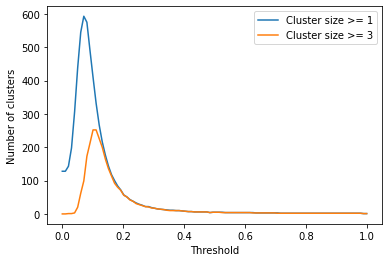

In [5]:
plt.plot(thresholds, y1)
plt.plot(thresholds, y2)
plt.xlabel("Threshold")
plt.ylabel("Number of clusters")

plt.legend(["Cluster size >= 1", "Cluster size >= 3"], loc = "best")

### Create stratified splits using the cluster-label

In [6]:
n_labels = max(y2)
threshold = thresholds[y2.index(n_labels)]

print(n_labels, threshold)

252 0.10101010101010102


In [7]:
# This number does not take into account experiments that did not get clustered
# Cannot pick n labels if n > 400 (80/20 split on 2000 experiments)
threshold = 0.22

clusters = t.Cluster(threshold)

In [8]:
clusters = sorted(clusters, key = lambda x: -len(x[1]))

In [9]:
_x, _y = zip(*[[k+1, len(yy)] for k, (xx, yy) in enumerate(clusters)])

Text(0, 0.5, 'Count')

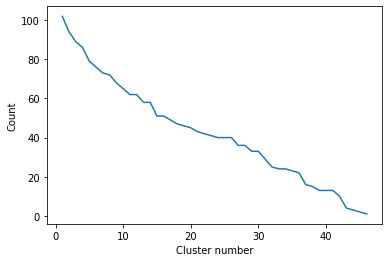

In [10]:
plt.plot(list(_x), list(_y))
plt.xlabel("Cluster number")
plt.ylabel("Count")

In [11]:
mydict = {
    "experiment": [],
    "centroid": []
}

centroids_with_cluster = set()
for x in sorted(clusters, reverse = True):
    mydict["centroid"].append(x[0])
    mydict["experiment"].append(x[0])    
    centroids_with_cluster.add(x[0])
    for x2 in x[1]:
        mydict["centroid"].append(x[0])
        mydict["experiment"].append(x2)
        centroids_with_cluster.add(x2)
        
not_clustered = list(set(range(2000)) - centroids_with_cluster)
for experiment in not_clustered:
    mydict["centroid"].append(experiment)
    mydict["experiment"].append(experiment)
        
df = pd.DataFrame.from_dict(mydict).drop_duplicates()
df = df.sort_values("experiment").reset_index(drop = True)

In [12]:
print(df.shape)
print("Total clusters:", df["centroid"].nunique())
print(df['centroid'].value_counts())

(2000, 2)
Total clusters: 46
343     103
1489     95
204      90
1865     87
940      80
422      77
819      74
1542     73
898      69
939      66
134      63
1300     63
225      59
99       59
332      52
1157     52
1671     50
1307     48
1150     47
564      46
319      44
667      43
1353     42
672      41
604      41
242      41
1737     37
60       37
653      34
1547     34
307      30
181      26
570      25
1255     25
827      24
1956     23
167      17
675      16
1997     14
420      14
697      14
1389     11
989       5
1805      4
1391      3
155       2
Name: centroid, dtype: int64


In [13]:
df.head()

,experiment,centroid
0,0,1489
1,1,675
2,2,1542
3,3,939
4,4,940


In [351]:
def stratified_split(df: pd.DataFrame,
                     frac: float,
                     column: List[str]) -> (pd.DataFrame, pd.DataFrame):
    
    label_count = df[column].value_counts().to_dict()
    labels_we_can_use = df[column].apply(lambda x: label_count[x] > 1)
    items_with_count_one = df[~labels_we_can_use].copy()
    items_needing_split = df[labels_we_can_use].copy()
    
    train, test = _train_test_split(
        items_needing_split,
        test_size=frac,
        stratify=items_needing_split[column]
    )
    train = pd.concat([train, items_with_count_one], axis = 0, sort = True).reset_index(drop = True)
    return train, test

In [352]:
def train_test_val_split(df: pd.DataFrame,
                         fraction: float = 0.2) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    
    fraction = min(1.0, fraction)
    train, _test = stratified_split(df, fraction, "centroid") 
    test, val = stratified_split(_test, 0.5, "centroid") 
    
    return train, test, val

In [353]:
train, test, val = train_test_val_split(df, 0.2)

In [360]:
train.shape

(1600, 2)

In [361]:
test.shape

(201, 2)

In [362]:
val.shape

(199, 2)

In [366]:
with open("train_test_val_splits.pkl", "wb") as fid:
    pickle.dump([
        list(train["experiment"]), list(test["experiment"]), list(val["experiment"])
    ], fid)

In [373]:
weights = df["centroid"].value_counts().to_dict()

In [375]:
df['weight'] = df['centroid'].map(weights)

In [377]:
df['weight'] = df['weight'].min() / df['weight']

In [382]:
df.to_csv("experiment_labels.csv")